<a href="https://colab.research.google.com/github/IamSVP94/NLP_project/blob/master/Sentiment_analysis_of_reviews_tonality_from_KinoPoisk_GC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis of reviews tonality from KinoPoisk

## Сбор данных

В качестве данных будут выступать отзывы на разные фильмы с сайта КиноПоиск

In [1]:
!pip install fake_useragent
!pip install googletrans
!pip install random

ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random


In [2]:
import time
import os
import random
import requests
from bs4 import BeautifulSoup
import pandas as pd
from fake_useragent import UserAgent
from tqdm import tqdm
import math
import numpy as np
import string
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
from googletrans import Translator as GT

In [3]:
# os.getcwd()
# os.mkdir('Data')

In [4]:
'''
Функция скачивает отзывы с КиноПоиска.
Нужно еще доработать для настройки аргументов
АРГУМЕНТЫ ФУНКЦИИ:
reviews_count - если нужно ограничить кол-во отзывов всех видов (по умолч. скачивает все отзывы)
review_type - если нужны отзывы определенного типа ['bad', 'good', 'neutral'] (по умолч. скачивает все типы отзывов)
together - True, если нужно сохранить все отзывы в 1 файл (по умолч. False)
download - True, если нужно скачивать отзывы
'''
def get_reviews_KinoPoisk(reviews_count=None, review_type=None, together=False, download=True):
    
    def download_reviews(df, reviews_type, together):  # сохраняет датафреймы в csv файлы
        if together:  # если нужно сохранить все вместе
            df.to_csv('Data/all_reviews.csv', index=False)
        else:
            df.to_csv('Data/'+str(reviews_type)+'_reviews.csv', index=False)


    def kinopoisk_revs(rtype, reviews_count):  # тянет отзывы с КиноПоиска
        rev_per_page = 200
        base_url = 'https://www.kinopoisk.ru/reviews/type/comment/status/{0}/period/month/perpage/{1}/page/{2}/'
        page_numb = 1
        r_counter = reviews_count
        # пустой дф для последующего добавления отзывов
        rev_df = pd.DataFrame(columns=['review_text', 'review_type'])
        while True:  # пока есть отзывы (выход из цикла с помощью break)
            # если нужно ограничить кол-во отзывов
            if reviews_count and math.ceil(r_counter/rev_per_page) < page_numb:
                break
            response = requests.get(base_url.format(rtype, rev_per_page, page_numb),
                                    headers={'User-Agent': UserAgent().chrome})
            assert response.status_code == 200, 'Код ответа сервера: {}'.format(
                response.status_code)  # если сервер не доступен, то ошибка
            # выгружаем страницу отзывов
            soup = BeautifulSoup(response.text, 'html.parser')
            reviews_texts = [tag.get_text(strip=True) for tag in soup.select(
                '.brand_words span')]  # вычленяем отзывы по селектору
            page_numb += 1  # итератор страниц
            # если отзывов нет на странице, то выход из цикла (или если это уже лишние отзывы)
            if not len(reviews_texts):
                break            
            rev_df = rev_df.append(pd.DataFrame({'review_text': reviews_texts, 'review_type': rtype}),
                                   ignore_index=True)  # сохраняем все отзывы в датафрейм
        if not reviews_count:
            return rev_df
        else:
            if reviews_count > len(rev_df):
                reviews_count = len(rev_df)
            return rev_df.loc[0:reviews_count-1,:]


    if isinstance(review_type, str):  # если указан тип нужных отзывов
        rev_df = kinopoisk_revs(review_type, reviews_count)  # вытягиваем отзывы
    else:
        if not review_type:
            review_type = ['neutral', 'good', 'bad']  # все варианты отзывов
        iter_types = tqdm(review_type)  # для отображения прогресс-бара
        if together:  # если нужены все отзывы в 1 датафрейме
            common_df = pd.DataFrame(columns=['review_text', 'review_type'])
        for rtype in iter_types:  # перебираем все виды отзывов
            iter_types.set_description('Processing "{}" reviews'.format(
                rtype), refresh=True)  # добавляем свое описание для прогресса
            # Датафрейм с отзывами опред. типа
            rev_df = kinopoisk_revs(rtype, reviews_count)
            if together:
                common_df = common_df.append(rev_df, ignore_index=True)
        if together:
            rev_df = common_df
    if download:  # если нужно скачать отзывы
        download_reviews(rev_df, rtype, together)
    else:
        return rev_df

# get_reviews_KinoPoisk(download=True, together=True)

In [5]:
KinoPoisk_df = pd.read_csv('Data/all_reviews.csv')
KinoPoisk_df

,review_text,review_type
0,История про поэта Янониса сейчас может показат...,neutral
1,"Вот казалось бы, есть главная героиня, о чьем ...",neutral
2,Все хорошо и изящно в этом фильме Витаутаса Жа...,neutral
3,"Для Жалакявичуса, похоже, этот фильм был очень...",neutral
4,"Название «Орел», довольно смущающее, но что по...",neutral
...,...,...
2458,"Некомфортно, непонятно, противно, даже больно ...",bad
2459,"Военная фантастика, клюква, не имеющая никакой...",bad
2460,С лирической линией явный перебор. На выходе: ...,bad
2461,Почему фильм называется «Джульбарс» не ясно. Н...,bad


## Выделение тестовой выборки

In [6]:
# разбили на тренировочную и тестовую выборку
X, X_test, y, y_test = train_test_split(KinoPoisk_df['review_text'], 
                                        KinoPoisk_df['review_type'],
                                        test_size=0.1, 
                                        random_state=2, 
                                        shuffle=True, 
                                        stratify=KinoPoisk_df['review_type'])

In [7]:
len(X), len(X_test)

(2216, 247)

## Первичный анализ

На первый взгляд сразу вырисовываются очевидные проблемы:
- Необработанные отзывы (со знаками препинания, символами разметки и т.п.);
- Разный размер отзывов;
- Несбалансированная выборка;
- Три категории.

In [8]:
X[0][:200]+'...'

'История про\xa0поэта Янониса сейчас может показаться совсем неинтересной. В\xa0ленте много революционного напала. Нечто между «Оптимистической трагедией» и\xa0«Как закалялась сталь». Тем\xa0более русскоязычную ве...'

In [9]:
len(X[0]), \
len(X[1]), \

(1252, 1125)

In [10]:
for t in y.unique():
    rev_count = len(y[y==t])
    print(t, rev_count, '-', round(rev_count/len(X)*100, 2), '%')

good 1410 - 63.63 %
bad 406 - 18.32 %
neutral 400 - 18.05 %


## Аугментация данных

Так как позитивных отзывов у нас больше, чем всех остальных, то наша модель при постоянной выдаче результата "good", будет достигать точности предсказания класса почти в 64%.<br>
Для устранения подобной проблемы, попробуем сгенерировать отзывы из оставшихся категорий.

In [11]:
def review_augmentator(phrase): # делает 2-ной перевод предложения и возвращает дубликат
    langs = ['de', 'es', 'pt', 'it', 'fr', 'ar', 'vi', 'ja', 'en']
    lang_sel = random.choices(langs)[0]
    from_ru = GT().translate(phrase, src='ru', dest=lang_sel).text
    to_ru = GT().translate(from_ru, src=lang_sel, dest='ru').text
    return {'text': to_ru, 'lang': lang_sel}    

def df_foreign_dublicator(df, y, types=None):
    df = df.reset_index(drop=True)
    y = y.reset_index(drop=True)
    if not types:
        types = y.unique()
    for rtype in types:
        rtype_indx_list = []
        for i,el in enumerate(y):
            if el == rtype:
                rtype_indx_list.append(i)
        iter_indx = tqdm(rtype_indx_list)
        for i in iter_indx:
            augmentator = review_augmentator(df[i])
            iter_indx.set_description('type: "{}"; lang: "ru-{}-ru" '.format(rtype, augmentator['lang']), refresh=True)
            df = df.append(pd.Series(augmentator['text']), ignore_index=True)
            y = y.append(pd.Series(rtype), ignore_index=True)
            
    return (df, y)

# X, y = df_foreign_dublicator(X, y, types=['bad', 'neutral'])
# pd.concat([X, y], axis=1, ignore_index=True).to_csv('Data/after_augmentation.csv', index=False, header=['review_text', 'review_type'])

In [12]:
KinoPoisk_df = pd.read_csv('Data/after_augmentation.csv')
KinoPoisk_df

,review_text,review_type
0,Данный фильм мне порекомендовала мама. Также с...,good
1,«Лара Крофт» (2018) — ремейк и новый взгляд на...,bad
2,"Думаю никто не будет спорить с тем, что «Смерт...",good
3,"Посмотрела, не поленилась. Зачем? — Не знаю. Я...",bad
4,Первое и самое главное — фильм не удался.Нет о...,bad
...,...,...
3017,"1. Прежде всего, важно отметить, что это грубы...",neutral
3018,«Трансформеры» для меня давно превратились во ...,neutral
3019,Экстремально попсовый мультик! Скроенный целик...,neutral
3020,"Увидев, Дюнкерк оставляет двойную эмоцию. С од...",neutral


In [13]:
X = KinoPoisk_df['review_text']
y = KinoPoisk_df['review_type']

In [14]:
for t in y.unique():
    rev_count = len(y[y==t])
    print(t, rev_count, '-', round(rev_count/len(X)*100, 2), '%')

good 1410 - 46.66 %
bad 812 - 26.87 %
neutral 800 - 26.47 %


### Предобработка

In [15]:
# удаление знаков препинания, замена Заглавных букв строчными, исправление пробелов
def sentence_preprocessor(sentence):
    sentece = sentence.replace('\xa0', ' ').replace('.', ' ').replace('—', ' ').replace('  ', ' ').lower()
    sentece = ''.join(ch for ch in sentece if ch not in set(string.punctuation))
    return sentece

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
stop_words= nltk.corpus.stopwords.words('russian')
def stopwords_deleter(sentence): # удаляет стоп-слова из предложения
    splits = sentence.split()
    for word in splits:
        if word in stop_words:
            splits.remove(word)
    return ' '.join(splits)

In [18]:
# удаляем стоп-слова и приводим строки в порядок
X = pd.Series([stopwords_deleter(sentence_preprocessor(sentence)) for sentence in KinoPoisk_df['review_text']])
# кодируем целевую переменную в формате one hot encoding
y = utils.to_categorical([0 if mark=='bad' else (1 if mark=='neutral' else 2) for mark in KinoPoisk_df['review_type']], len(KinoPoisk_df['review_type'].unique()))

### Токенизация

In [19]:
tokenizer = Tokenizer(num_words=10000)

In [20]:
tokenizer.fit_on_texts(X)

In [21]:
len(tokenizer.word_index), \
# tokenizer.word_index

(114710,)

In [22]:
words_count_mean = []
for sentence in X:
    words_count_mean.append(
        len( (stopwords_deleter(sentence_preprocessor(sentence))).split() )
    )
num_words = math.ceil(np.mean(words_count_mean))
num_words

257

В среднем отзыв состоит из 257 слов.

In [23]:
sequences = tokenizer.texts_to_sequences(X)

In [24]:
print(X[0], end='\n\n')
print(sequences[0], len(sequences[0]))

данный фильм порекомендовала мама также следует наверное отметить факт моя собственная семья очень похожа семейство фильма меня сестра которая является счастливой женой мамой легкомысленная неприкаянная первых минут головой погрузилась атмосферу наблюдала событиями экране буквально первого лица возможно именно поэтому воспринимала события близко сердцу была объективна оценке этого фильма однако говоря откровенно ктото бывает объективен выставляя оценку чемулибоданную картину бы отнесла остросоциальной тематике ней раскрывается животрепещущий вопрос эвтаназия также заставляет задуматься пересмотреть свое мнение множестве вещей семья отношения мужчиной женщиной измены наркотики любовь родной земле жажда жизни вопросы волновали волнуют множество людей всему свету будут актуальны все времена скандинавское кино стало меня открытием совсем недавно однако хочется отметить такие элементы высокая кинематографичность невероятно красивая визуализация каждый кадр практически высокохудожественное ф

In [25]:
X = pad_sequences(sequences, maxlen=num_words)

In [26]:
len(X[0]), X[0]

(257, array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  246,    4, 2294,   35,  698,  388,  396,  535,
        3996,  870,    7, 2337,    8,   89, 3105,   39,   69, 4723, 1344,
        5724,  343,  285, 2078,  445, 1896,  116,  453,  472,  590,  121,
          33,   49,  273, 2248, 7115,  553, 9526,  109,    8,   45,  287,
         381,  290,  785, 1586,  389,   30, 8192,  278, 1671,  250,   35,
         736, 1297, 2295,  266,  666, 1482,  870,  274, 2809, 2249, 4931,
        5174,  234, 3353, 1328, 7

### Выделение отложенной выборки

In [27]:
# выделили отложенную выборку
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2, shuffle=True, stratify=y)

## Создание модели

In [28]:
len(X_train), len(X_val), len(X_test)

(2719, 303, 247)

### Сверточная нейросеть

In [46]:
first_model = Sequential([
    layer.Embedding(15000, 512, input_length=num_words),
    layer.Dropout(0.2),
    layer.Conv1D(128, 5, padding='valid', activation='relu'),
    layer.Dropout(0.2),
    layer.Flatten(),
    layer.Dense(3, activation='softmax')
])

first_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['mae', 'categorical_accuracy', 'accuracy'])

first_model_path = 'first_best_model.h5'
checkpoint_first_model = ModelCheckpoint('Data/{}'.format(first_model_path),
                                         monitor='val_accuracy',
                                         save_best_only=True, verbose=True)

In [47]:
history_first_model = first_model.fit(X_train, 
                                      y_train, 
                                      epochs=25, 
                                      batch_size=400, 
                                      validation_data=(X_val, y_val),
                                      callbacks=[checkpoint_first_model],
                                     )

Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 1.0742 - mae: 0.4280 - categorical_accuracy: 0.4388 - accuracy: 0.4388
Epoch 00001: val_accuracy improved from -inf to 0.46535, saving model to Data/first_best_model.h5
7/7 [==============================] - 30s 4s/step - loss: 1.0742 - mae: 0.4280 - categorical_accuracy: 0.4388 - accuracy: 0.4388 - val_loss: 1.0422 - val_mae: 0.4272 - val_categorical_accuracy: 0.4653 - val_accuracy: 0.4653
Epoch 2/25
7/7 [==============================] - ETA: 0s - loss: 0.9537 - mae: 0.3983 - categorical_accuracy: 0.4991 - accuracy: 0.4991
Epoch 00002: val_accuracy improved from 0.46535 to 0.55116, saving model to Data/first_best_model.h5
7/7 [==============================] - 30s 4s/step - loss: 0.9537 - mae: 0.3983 - categorical_accuracy: 0.4991 - accuracy: 0.4991 - val_loss: 1.0030 - val_mae: 0.4106 - val_categorical_accuracy: 0.5512 - val_accuracy: 0.5512
Epoch 3/25
7/7 [==============================] - ETA: 0s - loss: 0.8209 - ma

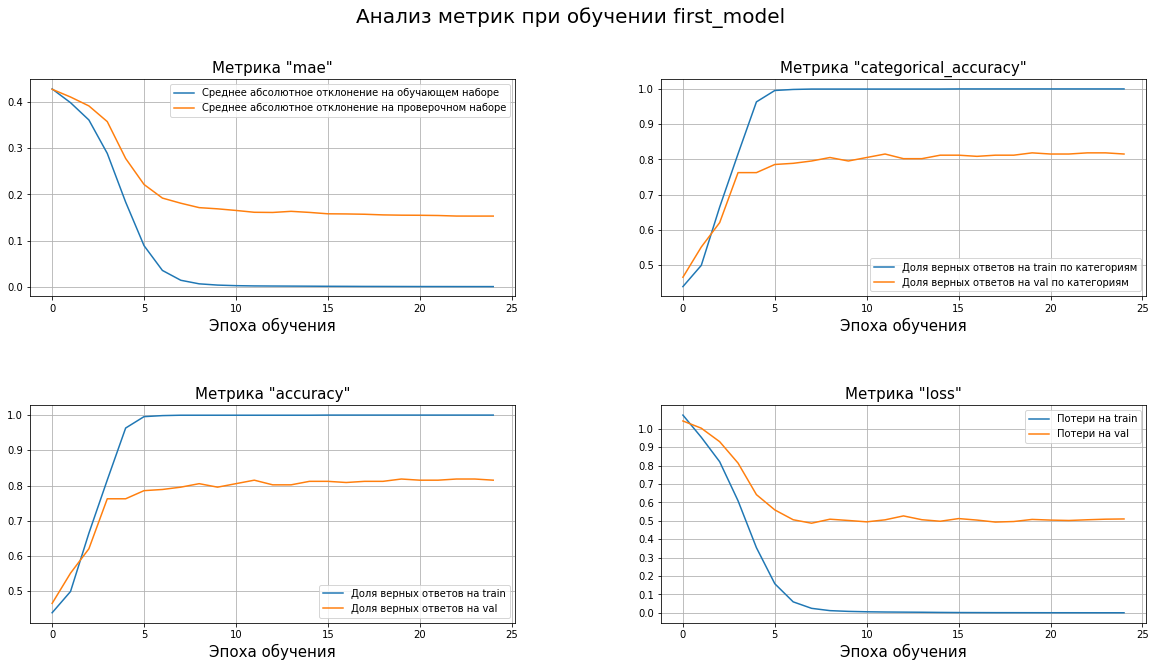

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.suptitle('Анализ метрик при обучении first_model', fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.5) # расстояние между графиками

for row_ax in ax:
    for ax_one in row_ax:
        ax_one.grid()
        ax_one.set_xlabel('Эпоха обучения', fontsize=15)
        ax_one.set_yticks(np.arange(0, 1.1, step=0.1))
        
ax[0,0].plot(history_first_model.history['mae'], 
             label='Среднее абсолютное отклонение на обучающем наборе')
ax[0,0].plot(history_first_model.history['val_mae'], 
             label='Среднее абсолютное отклонение на проверочном наборе')
ax[0,0].legend()
ax[0,0].set_title('Метрика "mae"', fontsize=15)


ax[0,1].plot(history_first_model.history['categorical_accuracy'], 
         label='Доля верных ответов на train по категориям')
ax[0,1].plot(history_first_model.history['val_categorical_accuracy'], 
         label='Доля верных ответов на val по категориям')
plt.xlabel('Эпоха обучения')
ax[0,1].legend()
ax[0,1].set_title('Метрика "categorical_accuracy"', fontsize=15)


ax[1,0].plot(history_first_model.history['accuracy'], 
         label='Доля верных ответов на train')
ax[1,0].plot(history_first_model.history['val_accuracy'], 
         label='Доля верных ответов на val')
ax[1,0].legend()
ax[1,0].set_title('Метрика "accuracy"', fontsize=15)


ax[1,1].plot(history_first_model.history['loss'], 
         label='Потери на train')
ax[1,1].plot(history_first_model.history['val_loss'], 
         label='Потери на val')
ax[1,1].legend()
ax[1,1].set_title('Метрика "loss"', fontsize=15);

In [49]:
first_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 257, 512)          7680000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 257, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 253, 128)          327808    
_________________________________________________________________
dropout_7 (Dropout)          (None, 253, 128)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 97155     
Total params: 8,104,963
Trainable params: 8,104,963
Non-trainable params: 0
____________________________________________

### Демонстрация модели

### Подготовка тестовой выборки для предсказания 

In [33]:
for t in y_test.unique():
    rev_count = len(y_test[y_test==t])
    print(t, rev_count, '-', round(rev_count/len(X_test)*100, 2), '%')

good 157 - 63.56 %
bad 45 - 18.22 %
neutral 45 - 18.22 %


In [34]:
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences_test, maxlen=num_words)
y_test = utils.to_categorical([0 if mark=='bad' else (1 if mark=='neutral' else 2) for mark in y_test], len(y_test.unique()))


In [35]:
print(X_test.shape, X_train.shape)
print(y_test.shape, y_train.shape)

(247, 257) (2719, 257)
(247, 3) (2719, 3)


In [51]:
# загружаем веса лучшей модели
first_model.load_weights('Data/{}'.format(first_model_path))
# Считаем качество на тестовой выборке
first_model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 1s 86ms/step - loss: 0.9592 - mae: 0.2374 - categorical_accuracy: 0.6883 - accuracy: 0.6883


[0.9592019319534302,
 0.23737795650959015,
 0.6882591247558594,
 0.6882591247558594]

**Качество данной модели (accuracy = 68.83%) оставляет желать лучшего...**<br>
Получается, что модель, только пресказывая всегда "good", достигнет точности 64%.
<hr>
Создадим другую модель с другими комбинациями скрытых слоев

### Вторая модель (LSTM)

In [37]:
second_model = Sequential([
    layer.Embedding(15000, 512, input_length=num_words),
    layer.Dropout(0.2),
    layer.LSTM(128),
    layer.Dropout(0.2),
    layer.Flatten(),
    layer.Dense(3, activation='softmax')
])

second_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['mae', 'categorical_accuracy', 'accuracy'])

second_model_path = 'second_best_model.h5'
checkpoint_first_model = ModelCheckpoint('Data/{}'.format(second_model_path),
                                         monitor='val_accuracy',
                                         save_best_only=True, verbose=True)

In [38]:
history_second_model = second_model.fit(X_train, y_train,
                                        epochs=15, 
                                        batch_size=400, 
                                        validation_data=(X_val, y_val),
                                        callbacks=[checkpoint_first_model],
                                       )

Epoch 1/15
7/7 [==============================] - ETA: 0s - loss: 1.0625 - mae: 0.4340 - categorical_accuracy: 0.4594 - accuracy: 0.4594
Epoch 00001: val_accuracy improved from -inf to 0.46535, saving model to Data/second_best_model.h5
7/7 [==============================] - 30s 4s/step - loss: 1.0625 - mae: 0.4340 - categorical_accuracy: 0.4594 - accuracy: 0.4594 - val_loss: 1.0147 - val_mae: 0.4112 - val_categorical_accuracy: 0.4653 - val_accuracy: 0.4653
Epoch 2/15
7/7 [==============================] - ETA: 0s - loss: 0.9608 - mae: 0.3926 - categorical_accuracy: 0.4730 - accuracy: 0.4730
Epoch 00002: val_accuracy improved from 0.46535 to 0.49835, saving model to Data/second_best_model.h5
7/7 [==============================] - 30s 4s/step - loss: 0.9608 - mae: 0.3926 - categorical_accuracy: 0.4730 - accuracy: 0.4730 - val_loss: 0.9271 - val_mae: 0.3851 - val_categorical_accuracy: 0.4983 - val_accuracy: 0.4983
Epoch 3/15
7/7 [==============================] - ETA: 0s - loss: 0.8234 - 

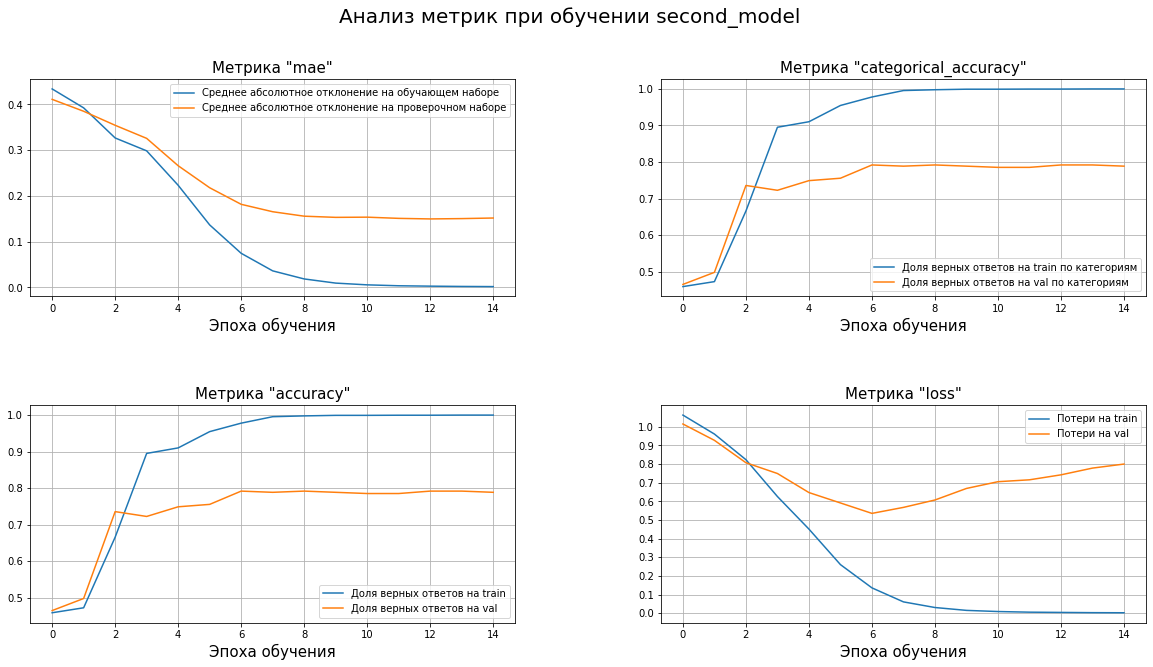

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.suptitle('Анализ метрик при обучении second_model', fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.5) # расстояние между графиками

for row_ax in ax:
    for ax_one in row_ax:
        ax_one.grid()
        ax_one.set_xlabel('Эпоха обучения', fontsize=15)
        ax_one.set_yticks(np.arange(0, 1.1, step=0.1))
        
ax[0,0].plot(history_second_model.history['mae'], 
             label='Среднее абсолютное отклонение на обучающем наборе')
ax[0,0].plot(history_second_model.history['val_mae'], 
             label='Среднее абсолютное отклонение на проверочном наборе')
ax[0,0].legend()
ax[0,0].set_title('Метрика "mae"', fontsize=15)


ax[0,1].plot(history_second_model.history['categorical_accuracy'], 
         label='Доля верных ответов на train по категориям')
ax[0,1].plot(history_second_model.history['val_categorical_accuracy'], 
         label='Доля верных ответов на val по категориям')
plt.xlabel('Эпоха обучения')
ax[0,1].legend()
ax[0,1].set_title('Метрика "categorical_accuracy"', fontsize=15)


ax[1,0].plot(history_second_model.history['accuracy'], 
         label='Доля верных ответов на train')
ax[1,0].plot(history_second_model.history['val_accuracy'], 
         label='Доля верных ответов на val')
ax[1,0].legend()
ax[1,0].set_title('Метрика "accuracy"', fontsize=15)


ax[1,1].plot(history_second_model.history['loss'], 
         label='Потери на train')
ax[1,1].plot(history_second_model.history['val_loss'], 
         label='Потери на val')
ax[1,1].legend()
ax[1,1].set_title('Метрика "loss"', fontsize=15);

После 6 эпохи растут потери. Может указывать на переобучение

In [40]:
second_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 257, 512)          7680000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 257, 512)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               328192    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 8,008,579
Trainable params: 8,008,579
Non-trainable params: 0
____________________________________________

In [41]:
# загружаем веса лучшей модели
second_model.load_weights('Data/{}'.format(second_model_path))
# Считаем качество на тестовой выборке
second_model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 1s 148ms/step - loss: 1.0323 - mae: 0.2962 - categorical_accuracy: 0.6316 - accuracy: 0.6316


[1.0322827100753784,
 0.2961544692516327,
 0.6315789222717285,
 0.6315789222717285]

### Сеть GRU

In [42]:
third_model = Sequential([
    layer.Embedding(15000, 512, input_length=num_words),
    layer.Dropout(0.2),
    layer.GRU(128),
    layer.Dropout(0.2),
    layer.Flatten(),
    layer.Dense(3, activation='softmax')
])

third_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['mae', 'categorical_accuracy', 'accuracy'])

third_model_path = 'third_best_model.h5'
checkpoint_first_model = ModelCheckpoint('Data/{}'.format(third_model_path),
                                         monitor='val_accuracy',
                                         save_best_only=True, verbose=True)

In [43]:
history_third_model = third_model.fit(X_train, y_train, 
                                      epochs=15, 
                                      batch_size=400, 
                                      validation_data=(X_val, y_val),
                                      callbacks=[checkpoint_first_model],
                                      )

Epoch 1/15
7/7 [==============================] - ETA: 0s - loss: 1.0642 - mae: 0.4339 - categorical_accuracy: 0.4296 - accuracy: 0.4296
Epoch 00001: val_accuracy improved from -inf to 0.46535, saving model to Data/third_best_model.h5
7/7 [==============================] - 25s 4s/step - loss: 1.0642 - mae: 0.4339 - categorical_accuracy: 0.4296 - accuracy: 0.4296 - val_loss: 1.0182 - val_mae: 0.4151 - val_categorical_accuracy: 0.4653 - val_accuracy: 0.4653
Epoch 2/15
7/7 [==============================] - ETA: 0s - loss: 0.9719 - mae: 0.3969 - categorical_accuracy: 0.4726 - accuracy: 0.4726
Epoch 00002: val_accuracy improved from 0.46535 to 0.48185, saving model to Data/third_best_model.h5
7/7 [==============================] - 25s 4s/step - loss: 0.9719 - mae: 0.3969 - categorical_accuracy: 0.4726 - accuracy: 0.4726 - val_loss: 0.9373 - val_mae: 0.3808 - val_categorical_accuracy: 0.4818 - val_accuracy: 0.4818
Epoch 3/15
7/7 [==============================] - ETA: 0s - loss: 0.7763 - ma

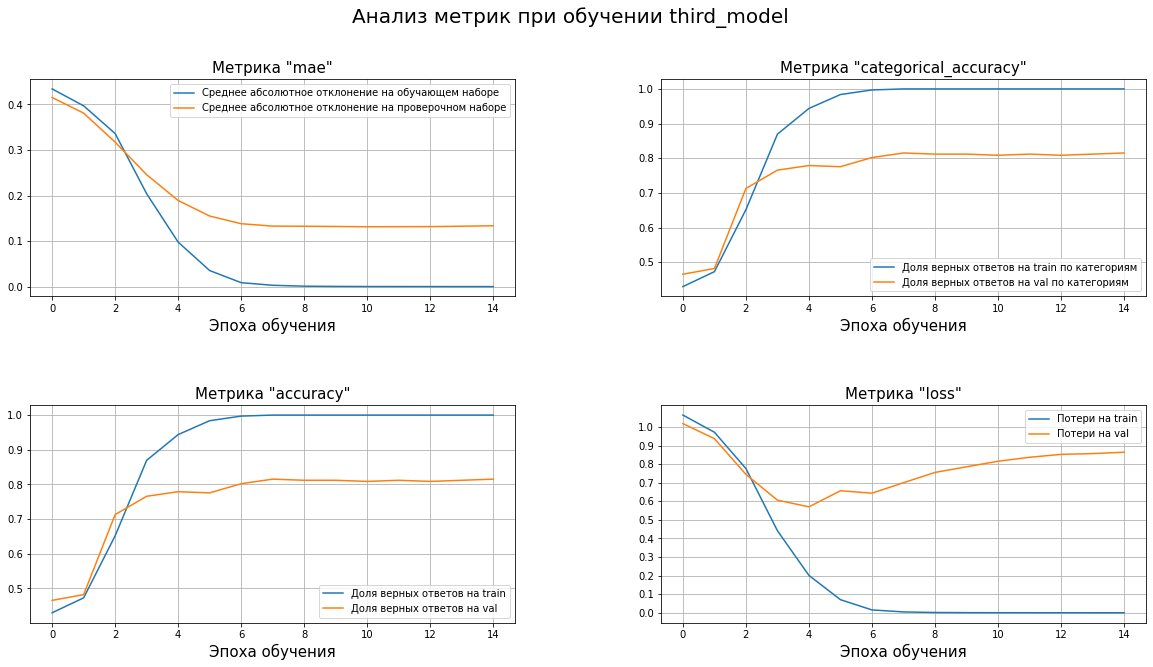

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.suptitle('Анализ метрик при обучении third_model', fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.5) # расстояние между графиками

for row_ax in ax:
    for ax_one in row_ax:
        ax_one.grid()
        ax_one.set_xlabel('Эпоха обучения', fontsize=15)
        ax_one.set_yticks(np.arange(0, 1.1, step=0.1))
        
ax[0,0].plot(history_third_model.history['mae'], 
             label='Среднее абсолютное отклонение на обучающем наборе')
ax[0,0].plot(history_third_model.history['val_mae'], 
             label='Среднее абсолютное отклонение на проверочном наборе')
ax[0,0].legend()
ax[0,0].set_title('Метрика "mae"', fontsize=15)


ax[0,1].plot(history_third_model.history['categorical_accuracy'], 
         label='Доля верных ответов на train по категориям')
ax[0,1].plot(history_third_model.history['val_categorical_accuracy'], 
         label='Доля верных ответов на val по категориям')
plt.xlabel('Эпоха обучения')
ax[0,1].legend()
ax[0,1].set_title('Метрика "categorical_accuracy"', fontsize=15)


ax[1,0].plot(history_third_model.history['accuracy'], 
         label='Доля верных ответов на train')
ax[1,0].plot(history_third_model.history['val_accuracy'], 
         label='Доля верных ответов на val')
ax[1,0].legend()
ax[1,0].set_title('Метрика "accuracy"', fontsize=15)


ax[1,1].plot(history_third_model.history['loss'], 
         label='Потери на train')
ax[1,1].plot(history_third_model.history['val_loss'], 
         label='Потери на val')
ax[1,1].legend()
ax[1,1].set_title('Метрика "loss"', fontsize=15);

In [45]:
# загружаем веса лучшей модели
third_model.load_weights('Data/{}'.format(third_model_path))
# Считаем качество на тестовой выборке
third_model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 1s 132ms/step - loss: 1.4714 - mae: 0.2546 - categorical_accuracy: 0.6235 - accuracy: 0.6235


[1.4714303016662598, 0.2546286880970001, 0.623481810092926, 0.623481810092926]

Качество модели GRU на тестовой выборке составляет 62.35%

## Что нужно изучить:
- приращивание данных (data-augmentation) 
- пакетная нормализация (batch normalization).
- embedding fasttext